In [48]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

train=pd.read_csv('train.csv', dtype={'Age': np.float64})
test = pd.read_csv('test.csv', dtype={'Age': np.float64})
PassengerId = test['PassengerId']
all_data = pd.concat([train, test], ignore_index=True)

Percentage of females who survived:74.20
Percentage of males who survived:18.89


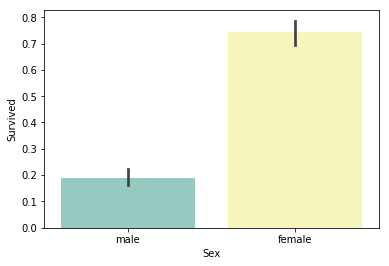

In [49]:
# Sex Feature: 女性幸存率远高于男性
sns.barplot(x='Sex', y='Survived', data=train, palette='Set3')
print("Percentage of females who survived:%.2f" %(train['Survived'][train['Sex']=='female'].value_counts(normalize=True)[1]*100))
print("Percentage of males who survived:%.2f" %(train['Survived'][train['Sex']=='male'].value_counts(normalize=True)[1]*100))

Percentage of Pclass = 1 who survived:62.96
Percentage of Pclass = 1 who survived:47.28
Percentage of Pclass = 1 who survived:24.24


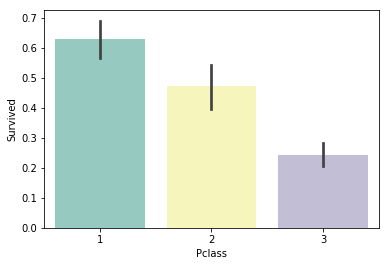

In [50]:
# Pclass Feature: 乘客社会等级越高，幸存率越高
sns.barplot(x='Pclass', y='Survived', data=train, palette='Set3')
print("Percentage of Pclass = 1 who survived:%.2f" % (train['Survived'][train['Pclass']==1].value_counts(normalize=True)[1]*100))
print("Percentage of Pclass = 1 who survived:%.2f" % (train['Survived'][train['Pclass']==2].value_counts(normalize=True)[1]*100))
print("Percentage of Pclass = 1 who survived:%.2f" % (train['Survived'][train['Pclass']==3].value_counts(normalize=True)[1]*100))

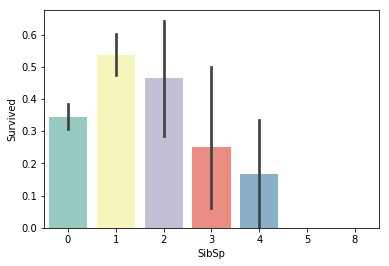

In [51]:
# SibSp Feature: 配偶及兄弟姐妹数适中的乘客幸存率更高
sns.barplot(x='SibSp', y='Survived', data=train, palette='Set3')

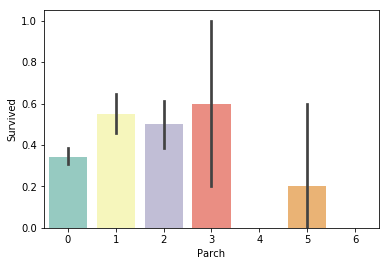

In [52]:
# Parch Feature: 父母与子女数适中的乘客幸存率更高
sns.barplot(x='Parch',y='Survived', data=train, palette='Set3')

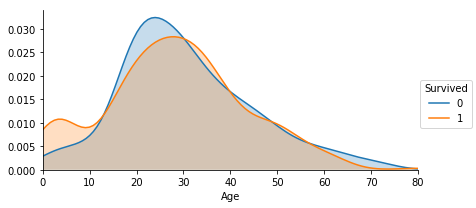

In [53]:
# Age Feature: 未成年人幸存率高于成年人
facet = sns.FacetGrid(train, hue='Survived', aspect=2)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

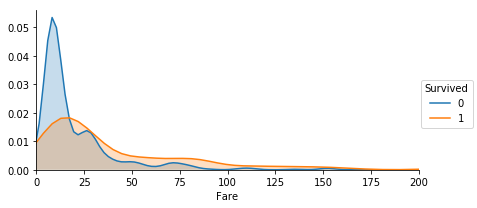

In [54]:
# Fare Feature: 支出船票费越高幸存率越高
facet = sns.FacetGrid(train, hue='Survived', aspect=2)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0,200))
facet.add_legend()

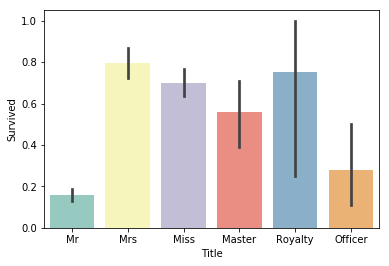

In [55]:
# Title Feature(New): 不同称呼的乘客幸存率不同
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x='Title', y ='Survived', data=all_data, palette='Set3')

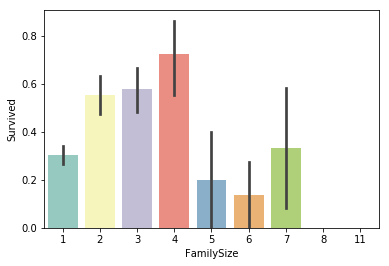

In [56]:
# FamilyLabel Feature(New): 家庭人数为2-4的乘客幸存率较高
# 新增 FamilyLabel 特征， 先计算FamilySize = Parch + SibSp + 1, 然后把FamilySize分成三类

all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
sns.barplot(x = 'FamilySize', y = 'Survived', data = all_data, palette='Set3')

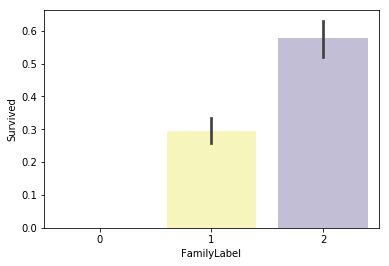

In [57]:
# 按生存率把FamilySize分为三类，构成FamilyLabel特征
def Fam_label(s):
    if (s>= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel'] = all_data['FamilySize'].apply(Fam_label)
sns.barplot(x = 'FamilyLabel', y = 'Survived', data=all_data, palette='Set3')

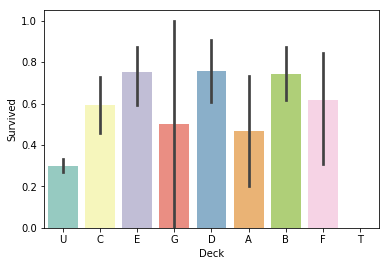

In [58]:
# Deck Feature(New): 不同甲板的乘客幸存率不同
# 新增Deck特征， 先把Cabin空缺值填充为‘Unknown', 再提取Cabin中的首字母构成乘客的甲板号
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck'] = all_data['Cabin'].str.get(0)
sns.barplot(x='Deck', y = 'Survived', data=all_data, palette='Set3')

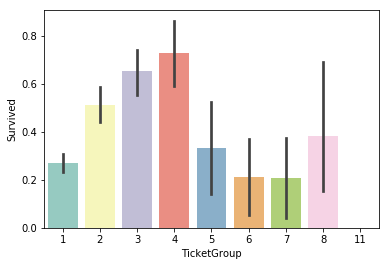

In [59]:
# TicketGroup Feature(New): 与2到4人共票号的乘客幸存率较高
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x: Ticket_Count[x])
sns.barplot(x = 'TicketGroup', y = 'Survived', data=all_data, palette='Set3')

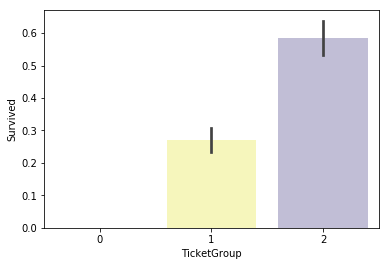

In [60]:
# 按生存率把TicketGroup分为三类
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0
    
all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

# 4.数据清洗

## 缺失值填充

In [61]:
# Age Feature: Age缺失量为263， 缺失量较大，用Sex, Title, Pclass三个特征构建随机森林模型，填充年龄缺失值
age_df = all_data[['Age', 'Pclass', 'Sex','Title']]
age_df = pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X,y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[(all_data.Age.isnull()), 'Age'] = predictedAges

In [62]:
# Embarked Feature: Embarked缺失量为2，缺失Embarked信息的乘客的Pclass均为1， 且Fare均为80，因为embark为C且Pclass为1的乘客的FARE中位数为80，所以缺失值填充为C
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


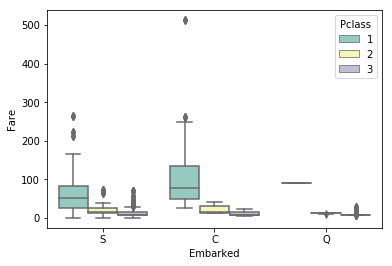

In [63]:
sns.boxplot(x='Embarked', y = 'Fare', hue='Pclass', data=all_data, palette='Set3')

In [64]:
# fare fratue: fare缺失量为1， 缺失fare信息的乘客的embarked为S，Pclass为3，所以用Embarked为S， Pclass为3的乘客的fare中位数填充
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [65]:
fare = all_data[(all_data['Embarked'] == 'S')&(all_data['Pclass'] == 3)].Fare.median()
all_data['Fare'] = all_data['Fare'].fillna(fare)

## 同组识别

In [66]:
# 把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性
all_data['Surname'] = all_data['Name'].apply(lambda x: x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x: Surname_Count[x])
Female_Child_Group = all_data.loc[(all_data['FamilyGroup'] >= 2) & ((all_data['Age'] <= 12) | (all_data['Sex'] == 'female') )]
Male_Adult_Group = all_data.loc[(all_data['FamilyGroup'] >= 2) & (all_data['Age']>12) & (all_data["Sex"]=='male')]

In [67]:
# 发现绝大部分女性和儿童组的平均存活率都为1或0，即同组的女性和儿童要么全部幸存，要么全部遇难
Female_Child = pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns = ['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5,0,'AverageSurvived')

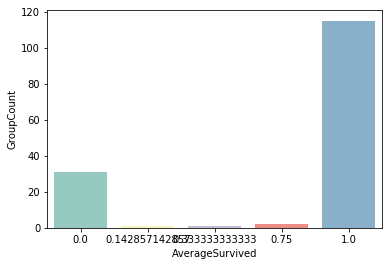

In [68]:
sns.barplot(x=Female_Child.index, y = Female_Child['GroupCount'], palette='Set3').set_xlabel('AverageSurvived')

In [69]:
Male_Adult = pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


Text(0.5,0,'AverageSurvived')

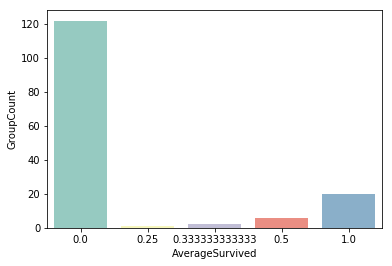

In [71]:
sns.barplot(x=Male_Adult.index, y = Male_Adult['GroupCount'], palette='Set3').set_xlabel('AverageSurvived')

In [72]:
Female_Child_Group = Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List = set(Female_Child_Group[Female_Child_Group.apply(lambda x: x==0)].index)
print(Dead_List)
Male_Adult_List = Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List = set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Panula', 'Robins', 'Zabour', 'Ford', 'Oreskovic', 'Strom', 'Danbom', 'Attalah', 'Barbara', 'Ilmakangas', 'Rosblom', 'Lefebre', 'Palsson', 'Caram', 'Turpin', 'Goodwin', 'Sage', 'Skoog', 'Olsson', 'Jussila', 'Bourke', 'Arnold-Franchi', 'Cacic', 'Lahtinen', 'Lobb', 'Rice', 'Vander Planke', 'Canavan', 'Boulos', 'Van Impe', 'Johnston'}
{'Harder', 'Jussila', 'Nakid', 'Dick', 'Beane', 'Beckwith', 'Bradley', 'Frolicher-Stehli', 'Cardeza', 'Duff Gordon', 'Chambers', 'Bishop', 'Frauenthal', 'Jonsson', 'Kimball', 'Greenfield', 'Goldenberg', 'McCoy', 'Taylor', 'Daly'}


In [73]:
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'


### 3.特征转化

In [74]:
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

# 5.建模与优化

## 1)参数优化

In [76]:
pipe = Pipeline([('select',SelectKBest(k=20)),
                 ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)),
              'classify__max_depth': list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring = 'roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 42} 0.8808044495672408


## 2）训练模型

In [79]:
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True,
                                n_estimators = 26,
                                max_depth = 6,
                                max_features = 'sqrt')
pipeline = make_pipeline(select,clf)
pipeline.fit(X,y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x1a13f706a8>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0,...estimators=26, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

## 3)交叉验证

In [81]:
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv=10)
print("CV score: Mean - %.7g | Std - %.7g" % (np.mean(cv_score), np.std(cv_score)))

CV score: Mean - 0.8440166 | Std - 0.03524286


In [82]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions.astype(np.int32)})
submission.to_csv("submission.csv", index=False)